**Data:** Average wage in Russia (1993-2016)

**Task:** Predict every month for two years ahead

In [31]:
import numpy as np

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [32]:
import pandas as pd

# reading the data

data = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=True, dayfirst=True)
data.columns = ['wage']

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


,wage
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


In [33]:
data.head(10)

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


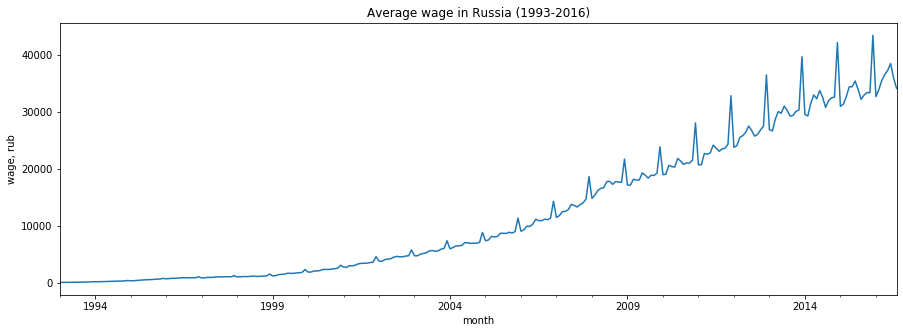

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualization

plt.figure(figsize=(15,5))
data.wage.plot()
plt.ylabel('wage, rub')
plt.title('Average wage in Russia (1993-2016)')

plt.show()

<Figure size 1080x360 with 0 Axes>

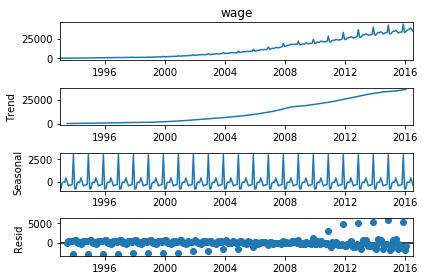

In [51]:
import statsmodels.api as sm

# stationarity check and STL decomposition

plt.figure(figsize=(15,5))
sm.tsa.seasonal_decompose(data.wage).plot()

plt.show()

In [38]:
# Dickey–Fuller test

round(sm.tsa.stattools.adfuller(data.wage)[1], 4)

0.9918

Optimal parameter of the Box-Cox transformation: 0.2632017541844584
Dickey–Fuller test: 0.6968987634832648


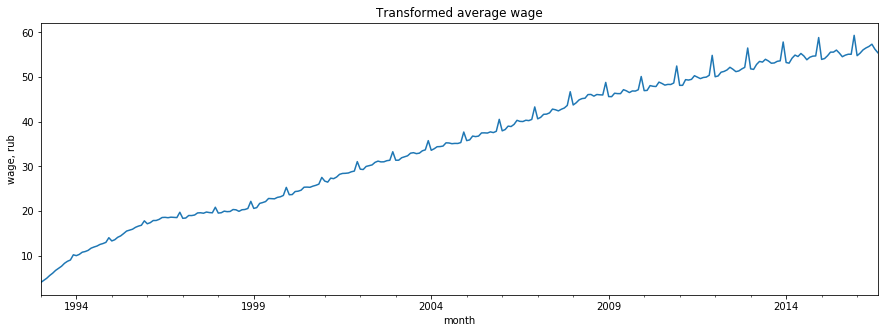

In [39]:
from scipy import stats

# Box–Cox transformation (dispersion stabilization)

data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize=(15,5))
data.wage_box.plot()
plt.ylabel('wage, rub')
plt.title('Transformed average wage')

print('Optimal parameter of the Box-Cox transformation:', lmbda)
print('Dickey–Fuller test:', sm.tsa.stattools.adfuller(data.wage_box)[1])

Dickey–Fuller test: 0.014697133494791847


<Figure size 1080x1080 with 0 Axes>

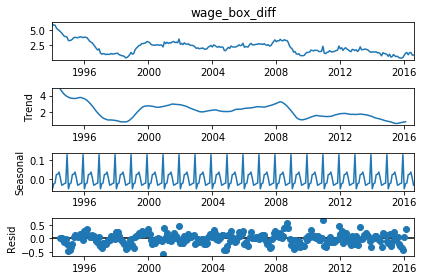

In [40]:
# seasonal differentiation

plt.figure(figsize=(15,15))

data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()

print('Dickey–Fuller test:', sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Dickey–Fuller test: 0.0196


<Figure size 1080x1080 with 0 Axes>

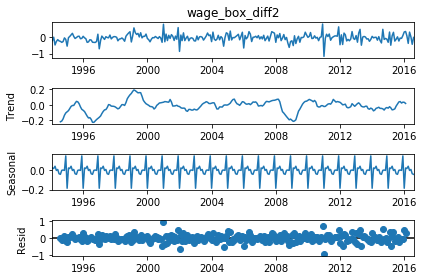

In [41]:
plt.figure(figsize=(15,15))

data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()

print('Dickey–Fuller test:', round(sm.tsa.stattools.adfuller(data.wage_box_diff[13:])[1], 4))

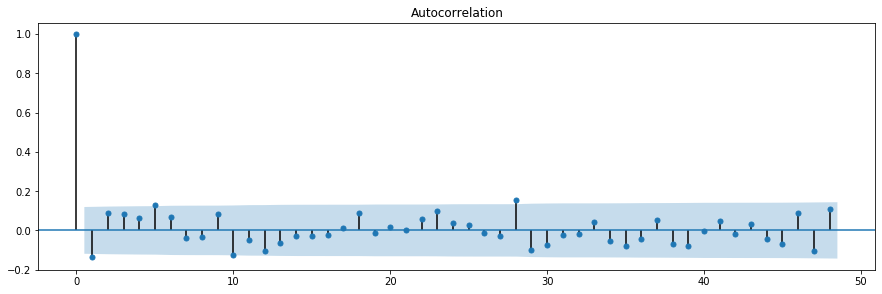

In [42]:
# ACF

plt.figure(figsize=(15,10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

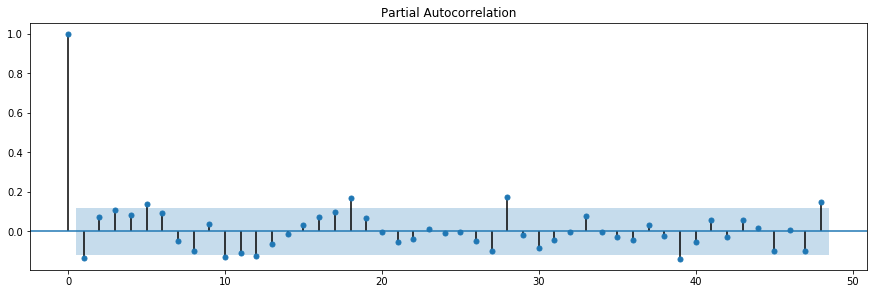

In [43]:
# PACF

plt.figure(figsize=(15,10))

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [44]:
from itertools import product

# Q = 0, q = 1, P = 1, p = 1

Ps = range(0, 2)
ps = range(0, 2)
Qs = range(0, 1)
qs = range(0, 2)
D=1
d=1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

print(len(parameters_list))
parameters_list

8


[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0)]

In [45]:
%%time
import warnings

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2.61 s, sys: 31.9 ms, total: 2.64 s
Wall time: 1.43 s


In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


In [47]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Fri, 28 Aug 2020   AIC                              0.341
Time:                                    12:10:26   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Student's t-test: 0.0908
Dickey–Fuller test: 0.0


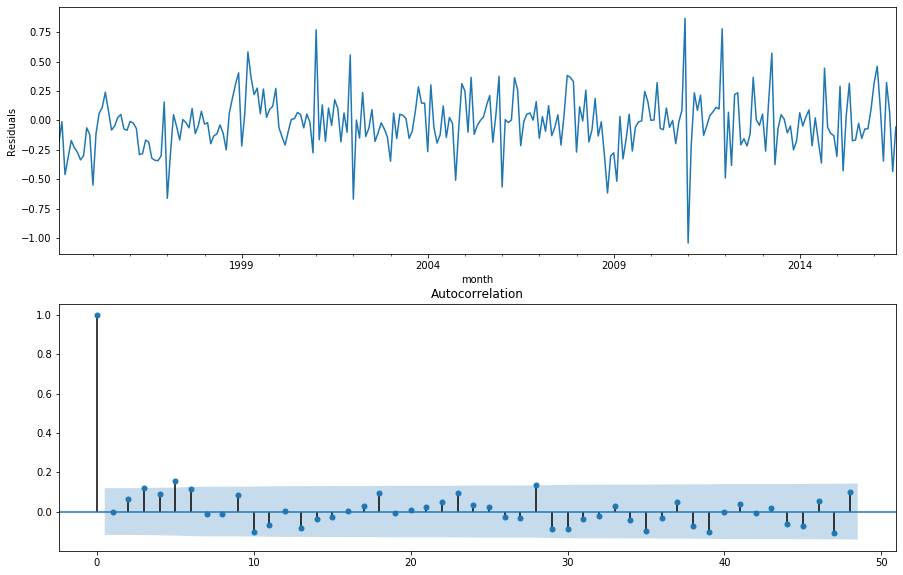

In [48]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's t-test:", round(stats.ttest_1samp(best_model.resid[13:], 0)[1], 4))
print('Dickey–Fuller test:', round(sm.tsa.stattools.adfuller(best_model.resid[13:])[1], 4))

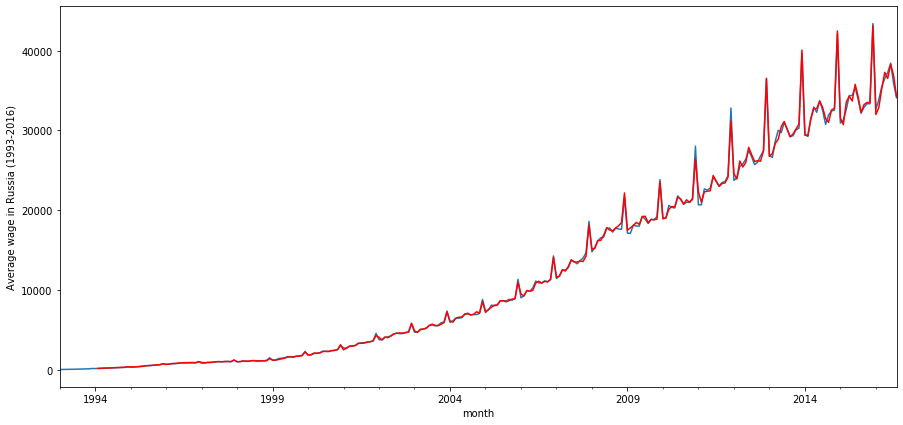

In [49]:
# building the model

data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
data.wage.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average wage in Russia (1993-2016)')

plt.show()

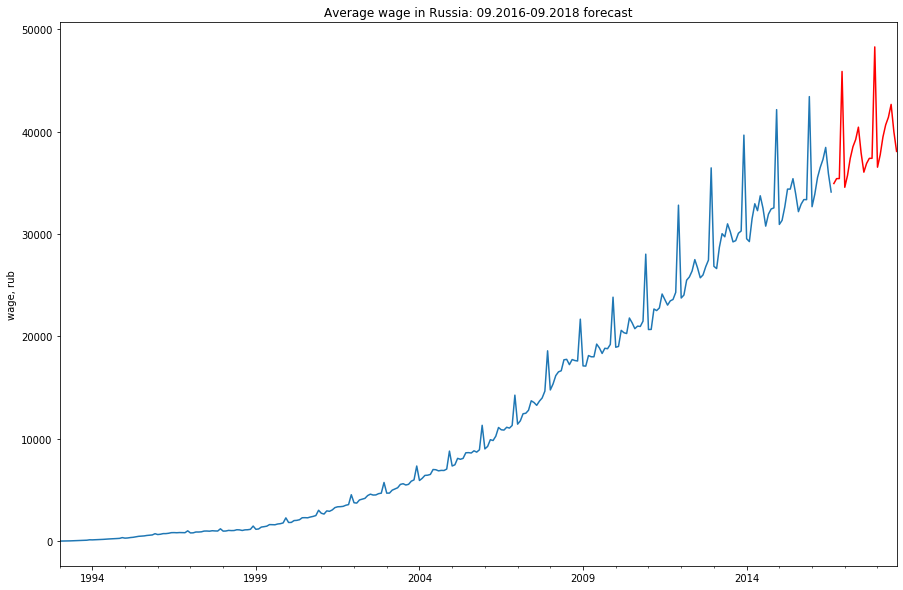

In [50]:
from datetime import *
from dateutil.relativedelta import *

# prediction

data2 = data[['wage']]
date_list = [datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize=(15,10))
data2.wage.plot()
data2.forecast.plot(color='r')
plt.ylabel('wage, rub')
plt.title('Average wage in Russia: 09.2016-09.2018 forecast')

plt.show()